In [27]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import numpy as np
import yaml

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

dataType='train2017'
annFile='/content/instances_train2017.json'
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=31.69s)
creating index...
index created!


In [67]:
def COCONames_to_COCOId(COCO_name):
    return coco.getCatIds(catNms=[COCO_name])[0];

def COCOId_to_COCONames(COCO_id):
  cats = coco.loadCats(coco.getCatIds())
  for c in cats:
    if c['id'] == COCO_id:
      return c['name']
  return -1

# Function to convert COCO format to YOLO
def convert_coco_to_yolo(coco, img_ids, output_labels_dir, output_img_dir):
    for img_id in img_ids:
        img_info = coco.loadImgs([img_id])[0]
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        annotations = coco.loadAnns(ann_ids)

        # Prepare YOLO format label
        label_file_path = Path(output_labels_dir + img_info['file_name'])
        label_file = label_file_path.with_suffix(".txt")
        with open(label_file, 'w+') as f:
            for ann in annotations:
                category_id = ann['category_id']
                if not category_id in catIds:
                  continue
                bbox = ann['bbox']
                segmentation = ann['segmentation']

                x = bbox[0]
                y = bbox[1]
                w = bbox[2]
                h = bbox[3]

                # Finding midpoints
                x_centre = (x + (x+w))/2
                y_centre = (y + (y+h))/2

                # Normalization
                x_centre = x_centre / img_info['width']
                y_centre = y_centre / img_info['height']
                w = w / img_info['width']
                h = h / img_info['height']

                # Limiting upto fix number of decimal places
                x_centre = format(x_centre, '.6f')
                y_centre = format(y_centre, '.6f')
                w = format(w, '.6f')
                h = format(h, '.6f')

                # Since YOLO train wants cat from 0 to N, we have to remap
                new_category_id = my_categories[COCOId_to_COCONames(category_id)]

                f.write(f"{new_category_id} {x_centre} {y_centre} {w} {h} ")
                #If segmentation exists, append the polygons (optional)
                if isinstance(segmentation, list):  # Polygons

                  segmentation_points_list = []
                  for segmentation in ann['segmentation']:

                    segmentation_points = [str(float(point) / (img_info['width']-1) if i % 2 == 0 else float(point) / (img_info['height']-1)) for i, point in enumerate(segmentation)]
                    segmentation_points_list.append(' '.join(segmentation_points))
                    segmentation_points_string = ' '.join(segmentation_points_list)
                    line = '{} '.format(segmentation_points_string)
                    f.write(line)
                    segmentation_points_list.clear()
                  f.write(f"\n")
                else:
                  f.write(f"\n")

        #print(f"Saved labels for {img_info['file_name']}")

        # Save the image into a local folder
        img_data = requests.get(img_info['coco_url']).content
        with open(output_img_dir + img_info['file_name'], 'wb') as handler:
            handler.write(img_data)

#print(COCONames_to_COCOId("cup"))
#print(COCOId_to_COCONames(47))
#print(my_categories[COCOId_to_COCONames(47)])

In [114]:
############# PARMAETERS
my_categories = {
    "person": 0,
    "sports ball": 1,
    "bottle": 2,
    "wine glass": 3,
    "cup": 3,
    "fork": 4,
    "knife": 5,
    "spoon": 6,
    "bowl": 7,
    "banana": 8,
    "apple": 9,
    "sandwich": 10,
    "orange": 11,
    "carrot": 12,
    "book": 13,
    "clock": 14,
    "vase": 15,
    "scissors": 16,
    "toothbrush": 17,
}

#laser is 309/76 (80/20)

#for each category, it is assured that AT LEAST this number of occurencies exist
# (because on same image multiple categories can be present, and also multiple occurencies
# of same category)
N_sample_train = 400
N_sample_valid = 100

output_name = "./coco_subset"


In [121]:
# get all images containing given categories, select at random
catIds = coco.getCatIds(list(my_categories.keys()));
imgIds = []
for cat in catIds:
  imgIdsAll = coco.getImgIds(catIds=cat)
  to_select = N_sample_train+N_sample_valid
  if len(imgIdsAll) < N_sample_train+N_sample_valid:
    to_select = len(imgIdsAll)
    print(f"WARNING: cat {cat} has only {len(imgIdsAll)}, when {N_sample_train+N_sample_valid} requested")

  imgIdsSelection = np.random.choice(imgIdsAll, size=to_select, replace=False)
  imgIds += imgIdsSelection.tolist()

#remove duplicates
random_imgIds = list(dict.fromkeys(imgIds))

print(f"Selected {len(random_imgIds)} images removing duplicates from {len(imgIds)}")

random_imgIds_train = random_imgIds[:N_sample_train]
random_imgIds_valid = random_imgIds[N_sample_train:]

9500
8592
Selected 8592 images removing duplicates from 9500


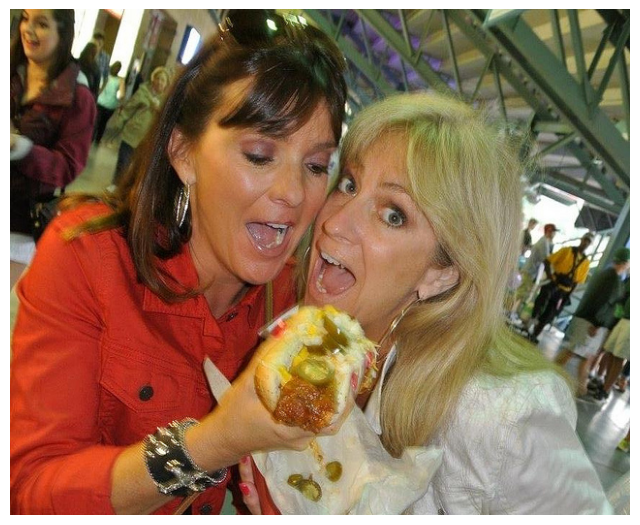

[{'segmentation': [[260.17, 322.99, 298.88, 293.66, 310.61, 244.39, 317.64, 215.07, 334.07, 179.88, 351.66, 128.26, 369.26, 97.76, 413.83, 86.03, 467.79, 87.21, 517.06, 137.65, 535.83, 197.47, 529.96, 250.26, 512.37, 300.7, 513.54, 335.89, 548.73, 360.52, 572.19, 391.02, 603.87, 471.96, 623.81, 513.02, 623.81, 516.54, 235.53, 514.19, 229.67, 473.13, 266.03, 455.54, 325.86, 446.15, 355.18, 395.71, 377.47, 358.18, 364.57, 317.12, 339.93, 307.74, 308.26, 304.22, 294.18, 310.08]], 'area': 94356.90890000002, 'iscrowd': 0, 'image_id': 467889, 'bbox': [229.67, 86.03, 394.14, 430.51], 'category_id': 1, 'id': 487861}, {'segmentation': [[561.05, 359.81, 581.23, 311.87, 603.94, 274.86, 623.28, 270.66, 624.97, 256.36, 626.65, 246.27, 633.38, 247.11, 639.26, 247.95, 639.26, 274.86, 634.22, 284.95, 634.22, 298.41, 625.81, 306.82, 624.12, 318.6, 619.08, 336.26, 601.42, 370.74, 597.21, 396.81, 604.78, 406.06, 582.07, 399.34, 583.75, 383.36, 589.64, 361.49, 579.55, 355.6, 569.46, 370.74, 561.05, 365.69

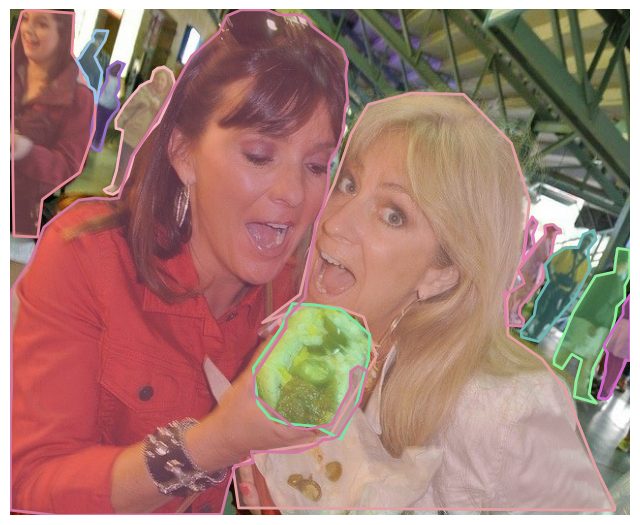

In [122]:
selected_images = coco.loadImgs(random_imgIds)

img = selected_images[8]
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
print(anns)

In [ ]:
import json
from pathlib import Path
import os
import requests
import time

#append timestamp to output dir
output_dir = output_name + "_" + str(int(time.time()))

# Create output directories if they don't exist
Path(output_dir+"/train/labels/").mkdir(parents=True, exist_ok=True)
Path(output_dir+"/train/images/").mkdir(parents=True, exist_ok=True)
Path(output_dir+"/valid/labels/").mkdir(parents=True, exist_ok=True)
Path(output_dir+"/valid/images/").mkdir(parents=True, exist_ok=True)

# Convert annotations
convert_coco_to_yolo(coco, random_imgIds_train, output_dir+"/train/labels/", output_dir+"/train/images/")
convert_coco_to_yolo(coco, random_imgIds_valid, output_dir+"/valid/labels/", output_dir+"/valid/images/")

# Create yaml
yaml_to_dump = {
    "train": "./train/images",
    "val": "./valid/images",
    "nc": len(my_categories),
    "names": dict(zip(my_categories.values(), my_categories.keys()))
}

#dump to data.yaml
with open(output_dir + "/data.yaml", "w+") as outfile:
    yaml.dump(yaml_to_dump, outfile, default_flow_style=False)



Download

In [66]:
import shutil
shutil.make_archive(output_dir, 'zip', output_dir)

from google.colab import files
files.download(output_dir + ".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**VISUALIZA MASK to see if it is correct**

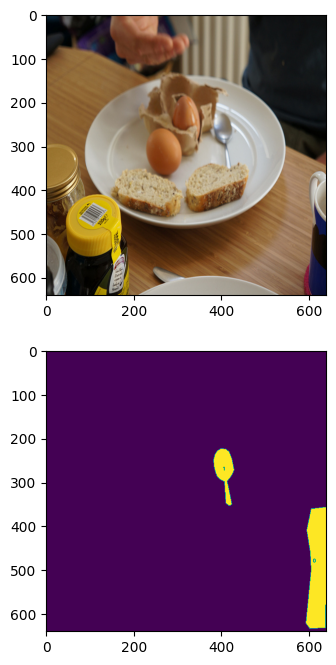

In [58]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw,ImageFont
import random
from matplotlib import pyplot as plt

image_path = "./"+ output_dir +"/train/images/000000138385.jpg"  # path of the image, change it
annotation_path = "./"+ output_dir +"/train/labels/000000138385.txt"  # path of the annotation text file, change it

# The Helper functions below assume that the image size is (640,640).Hence resizing the image.
#Open the image
img = Image.open(image_path)
#Resize the image to 640 by 640
img = img.resize((640, 640))
#if you want then you can save the resized image by img.save('resized_image.jpg')

# <--------- Helper functions starts here ----------------------------------->
def maskVisualize(image,mask):
  fontsize = 18
  f, ax = plt.subplots(2, 1, figsize=(8, 8))
  ax[0].imshow(image)
  ax[1].imshow(mask)

#Define the boundary coordinates as a list of (x, y) tuples
'''
def draw_points_on_image(image, points):
  #resize image to 640*640
  resimg = cv2.resize(image, (640,640))
  #iterate for each mask
  for mask in points:
    #Draw each point on the image
    for point in mask:
        cv2.circle(resimg, tuple(point), 1, (0,0,255), -1,)
  #Display the image
  cv2_imshow(resimg)
'''
#convert the mask from the txt file(annotation_path is path of txt file) to array of points making that mask.
def generate_points(annotation_path=''):
  labels=[] # this will store labels
  #we are assuming that the image is of dimension (640,640). then you have annotated it.
  with open(annotation_path, "r") as file:
    points=[]
    for line in file:
      label,bbox,lis=line.split()[0],line.split()[1:5], line.split()[5:]
      labels.append(label)
      lis=list(map(float,lis))
      for i in range(len(lis)):
        lis[i]=int(lis[i]*640)
      newlis=[]
      i=0
      while(i<len(lis)):
        #appendint the coordinates as a tuple (x,y)
        newlis.append((lis[i],lis[i+1]))
        i+=2
      points.append(newlis)
    return labels,points


#the below function convert the boundary coordinates to mask array (it shows mask if you pass 1 at show)
#the mask array is required when we want to augument the mask also using albumentation
def convert_boundary_to_mask_array(labels,points, show=0):
  #Create a new image with the same size as the desired mask
  mask = Image.new("L", (640, 640), 0)
  draw = ImageDraw.Draw(mask)
  for i,boundary_coords in enumerate(points):
    #boundary_coords represent boundary of one polygon
    #Draw the boundary on the mask image
    if len(boundary_coords) == 0:
      continue
    draw.polygon(boundary_coords,fill=1)
    #Also put the label as text
    #Compute the centroid of the polygon
    centroid_x = sum(x for x, _ in boundary_coords) / len(boundary_coords)
    centroid_y = sum(y for _, y in boundary_coords) / len(boundary_coords)
    centroid = (int(centroid_x), int(centroid_y))
    #Write the name at the centroid
    text = str(labels[i])
    #Write the label at the centroid
    font = ImageFont.load_default()
    font.size = 30
    #text_w, text_h = draw.textsize(text, font=font)
    text_w = draw.textlength(text, font=font)
    text_h = font.size * 1
    text_pos = (centroid[0] - text_w/2, centroid[1] - text_h/2)
    draw.text(text_pos, text, font=font, fill='black')
  #Convert the mask image to a numpy array
  mask_array = np.array(mask)*255
  #Show the mask image
  if(show==1):
    #Image.fromarray(mask_array).show()
    cv2_imshow(mask_array)
  return mask_array

#function that takes mask path (yolov8 seg txt file) and return mask of an image (shape of mask == shape of image)
def generate_mask(annotation_path='',show=0):
  #pass show=1 for showing the generated mask
  #firstly we generate the points (coordinates) from the annotations
  labels,points=generate_points(annotation_path)
  #once we get the points we will now generate the mask image from these points (binary mask image (black/white))
  #mask is represented by white and ground is represented as black
  mask_array=convert_boundary_to_mask_array(labels,points,show)
  return mask_array
# <---------- Helper Functions Ends here ------------------------------------------------------------->

mask_array=generate_mask(annotation_path=annotation_path,show=0)
maskVisualize(np.array(img),mask_array)


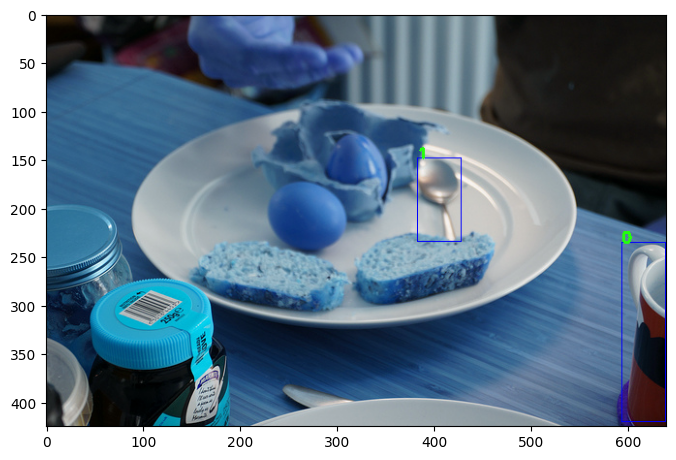

In [59]:
##Show bboxes
img = cv2.imread(image_path)
dh, dw, _ = img.shape

with open(annotation_path, "r") as file:
  points=[]
  for dt in file:
    label,bbox=dt.split()[0],dt.split()[1:5]

    # Split string to float
    x = float(bbox[0])
    y = float(bbox[1])
    w = float(bbox[2])
    h = float(bbox[3])

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)
    cv2.putText(img, label, (l, t), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)


plt.imshow(img)
plt.show()

In [60]:
!rm -r prova*